catboost ことはじめ

In [1]:
pip install catboost --user

You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from catboost import CatBoostClassifier, Pool, cv
from catboost.datasets import adult

from copy import deepcopy
import numpy as np

%matplotlib inline

## 学習

API は scikit-learn like な使用になっているので混乱はしないと思う。インスタンスを作成する際に構造に対するパラメータ情報を渡して, fit のときに学習に関するデータを渡す。

ぱっと確認した感じではほとんど xgboost/lightGBM と変わらないように見えた。  
lightGBM 同様に大量に alias がはられているので今までのコードで class だけ catboost に変えただけでも動きそう

例えば作成する木の数は `iterations` がデフォルトだけどその他に
* num_boost_round
* n_estimators
* num_trees

などでもいける

参考

* [catboost parameter 一覧](https://catboost.ai/docs/concepts/python-reference_parameters-list.html)

In [3]:
X = np.random.uniform(size=(100, 10))
y = np.random.randint(0, 2, size=(100,))

default_params = {
    'iterations': 1000,
    'depth': 3,
    'loss_function': 'Logloss',
    'verbose': False
}

model = CatBoostClassifier(**default_params)
model.fit(X, y)

## Catboost 独自の実装

scikit-learn like な使い方をするだけなら上記だけ知っていれば十分だけれど catboost の本領が発揮されるのはカテゴリ変数の取扱が出てきたときです。(catboost 論文でも categorical feature の取扱をうまくするための工夫に関して 1 section が取られています)

catboost では特徴量のうちどのカラムがカテゴリ変数なのかを構造として持つクラス `FeaturesData` があります。

FeaturesData では数値の特徴量とカテゴリの特徴量を別々に渡すようなインターフェースになっており、数値は数として, カテゴリのものはカテゴリ変数に有利な処理を施して、学習を行うように設定されます。

この FeaturesData の上位概念として `Pool` クラスが用意されています。Pool クラスには FeatuersData よりもたくさんのインスタンスメソッドが用意されているので、こちらのほうが何かと便利かなという印象です。

> [TODO] 内部的な処理がどう違うのかはよくわかっていないのでまた調べる

普通に X, y で fit するときとの最大の違いは特徴量に名前をつけて取り扱えるという点でしょうか。
カテゴリ変数の指定もカラム名で行えるので若干楽です。

> The fastest way to pass the features data to the Pool constructor (and other CatBoost, CatBoostClassifier, CatBoostRegressor methods that accept it) if most (or all) of your features are numerical is to pass it using FeaturesData class. Another way to get similar performance with datasets that contain numerical features only is to pass features data as numpy.ndarray with numpy.float32 dtype.

In [4]:
adult_train, adult_test = adult()
adult_train_label = adult_train.pop('income')

In [5]:
# binary に変換
adult_train_label = np.where(adult_train_label == '<=50K', 0, 1)

In [6]:
adult_train.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')

In [7]:
for name, col in adult_train.T.iterrows():
    print(name, len(col.unique()), col.dtype)

age 73 object
workclass 9 object
fnlwgt 21648 object
education 16 object
education-num 16 object
marital-status 7 object
occupation 15 object
relationship 6 object
race 5 object
sex 2 object
capital-gain 119 object
capital-loss 92 object
hours-per-week 94 object
native-country 42 object


In [8]:
for c in adult_train.columns:
    print(c, adult_train[c].dtype)

age float64
workclass object
fnlwgt float64
education object
education-num float64
marital-status object
occupation object
relationship object
race object
sex object
capital-gain float64
capital-loss float64
hours-per-week float64
native-country object


In [9]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

import pandas as pd

In [10]:
n_folds = 4
fold = KFold(n_splits=n_folds)

## Trainig with Pool

pool class を使って学習して見ましょう。先程の雑すぎる EDA でユニーク数が少なかったカラムをカテゴリとして扱ってみます。

In [11]:
def create_normal_feature(df_input, one_hot=True):
    df_input = adult_train
    df_out = pd.DataFrame()

    cat_cols = []
    for name, col in df_input.iteritems():
        if col.dtype == 'object':
            cat_cols.append(name)
    for c in cat_cols:
        s_i = pd.Categorical(df_input[c], categories=adult_train[c].dropna().unique())
        
        if one_hot:
            df_i = pd.get_dummies(s_i).add_prefix(f'{c}_')
        else:
            df_i = pd.DataFrame(s_i.codes, columns=[f'{c}_cat'])
        df_out = pd.concat([df_out, df_i], axis=1)

    # 数値のカラムを普通に入れる
    df_out = pd.concat([df_out, df_input[[c for c in df_input.columns if c not in cat_cols]]], axis=1)
    return df_out

In [12]:
def get_data_pool(idx, use_cat=True):
    if use_cat:
        cat_featues = adult_train.columns
        data = adult_train.fillna(0)
    else:
        cat_featues = None
        data = create_normal_feature(adult_train)

    return Pool(data=data.loc[idx],
                 label=adult_train_label[idx],
                 cat_features=cat_featues)

In [13]:
params = {
    'n_estimators': 2000,
    'learning_rate': 0.3,
    'reg_lambda': 10.,
    'eval_metric':'AUC',
    'random_seed': 0,    
    'verbose': 200
}

def fit_oof(params=None, use_category=True):
    if params is None:
        params = {}
    oof_pred = np.zeros_like(adult_train_label).astype(np.float32)
    models = []
    for train_idx, valid_idx in fold.split(adult_train, adult_train_label):
        train_pool = get_data_pool(train_idx, use_category)
        valid_pool = get_data_pool(valid_idx, use_category)

        clf = CatBoostClassifier(**params)
        clf.fit(train_pool, 
                eval_set=valid_pool,
                early_stopping_rounds=200)
        oof_pred[valid_idx] = clf.predict_proba(valid_pool)[:, 1]
        models.append(clf)
    return models, oof_pred

In [14]:
results = {}

In [15]:
models, oof_pred = fit_oof(params=params)
score = roc_auc_score(adult_train_label, oof_pred)
print('use cat: {:.5f}'.format(score))

results['auc_use_cat'] = score

0:	test: 0.8677022	best: 0.8677022 (0)	total: 28.3ms	remaining: 56.6s
200:	test: 0.9299103	best: 0.9300405 (179)	total: 7.32s	remaining: 1m 5s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.9300404713
bestIteration = 179

Shrink model to first 180 iterations.
0:	test: 0.8719703	best: 0.8719703 (0)	total: 47.4ms	remaining: 1m 34s
200:	test: 0.9291182	best: 0.9296149 (117)	total: 7.67s	remaining: 1m 8s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.9296149176
bestIteration = 117

Shrink model to first 118 iterations.
0:	test: 0.8798660	best: 0.8798660 (0)	total: 51.1ms	remaining: 1m 42s
200:	test: 0.9329623	best: 0.9330830 (191)	total: 7.57s	remaining: 1m 7s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.9330829676
bestIteration = 191

Shrink model to first 192 iterations.
0:	test: 0.8710901	best: 0.8710901 (0)	total: 40.4ms	remaining: 1m 20s
200:	test: 0.9318316	best: 0.9319278 (158)	total: 7.67s	remaining: 1m 8s
400:	tes

* カテゴリ変数なしのとき

In [16]:
models, oof_pred = fit_oof(params=params, use_category=False)
score = roc_auc_score(adult_train_label, oof_pred)
print('none-cat: {:.5f}'.format(score))

results['auc_not_use_cat'] = score

0:	test: 0.8603344	best: 0.8603344 (0)	total: 19.4ms	remaining: 38.7s
200:	test: 0.9284982	best: 0.9285433 (184)	total: 3.85s	remaining: 34.4s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.9285432671
bestIteration = 184

Shrink model to first 185 iterations.
0:	test: 0.8669922	best: 0.8669922 (0)	total: 18.5ms	remaining: 36.9s
200:	test: 0.9238254	best: 0.9239651 (121)	total: 3.48s	remaining: 31.2s
400:	test: 0.9245544	best: 0.9246921 (247)	total: 6.84s	remaining: 27.3s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.9246921196
bestIteration = 247

Shrink model to first 248 iterations.
0:	test: 0.8683693	best: 0.8683693 (0)	total: 18.2ms	remaining: 36.4s
200:	test: 0.9318046	best: 0.9319130 (198)	total: 3.73s	remaining: 33.4s
400:	test: 0.9317505	best: 0.9319147 (309)	total: 7.4s	remaining: 29.5s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.9319146795
bestIteration = 309

Shrink model to first 310 iterations.
0:	test: 

## その他の boosting と比較

lightGBM と比較する

In [17]:
import lightgbm as lgbm

In [18]:
def fit_lgbm(X, y, params: dict=None, verbose=200):

    # パラメータがないときはからの dict で置き換える
    if params is None:
        params = {}

    models = []

    # training data の target と同じだけのゼロ配列を用意
    oof_pred = np.zeros_like(y).astype(np.float)

    for idx_train, idx_valid in fold.split(X, y):
        # training data を trian/valid に分割
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgbm.LGBMClassifier(**params)
        clf.fit(x_train, y_train, 
                eval_set=[(x_valid, y_valid)], 
                early_stopping_rounds=200, 
                eval_metric='auc',
                verbose=verbose)

        pred_i = clf.predict_proba(x_valid)[:, 1]
        oof_pred[idx_valid] = pred_i
        models.append(clf)
    return models, oof_pred

In [19]:
params = {
    'learning_rate': 0.1,
    'n_estimators': 1000,
    'reg_lambda': 10.
}
X = create_normal_feature(adult_train).values

In [20]:
models, oof = fit_lgbm(X, y=adult_train_label, params=params)
score = roc_auc_score(adult_train_label, oof)

results['lgbm_one-hot'] = score
score

Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.927588	valid_0's binary_logloss: 0.28017
Early stopping, best iteration is:
[159]	valid_0's auc: 0.928081	valid_0's binary_logloss: 0.279305
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.924279	valid_0's binary_logloss: 0.284813
[400]	valid_0's auc: 0.923018	valid_0's binary_logloss: 0.287648
Early stopping, best iteration is:
[201]	valid_0's auc: 0.924303	valid_0's binary_logloss: 0.284755
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.92915	valid_0's binary_logloss: 0.277331
[400]	valid_0's auc: 0.928247	valid_0's binary_logloss: 0.279136
Early stopping, best iteration is:
[211]	valid_0's auc: 0.92924	valid_0's binary_logloss: 0.277144
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.9305	valid_0's binary_logloss: 0.276053
Early stopping, best iteration is:
[177]	valid_0's auc: 0.93072

0.9280486687476706

In [21]:
X = create_normal_feature(adult_train, one_hot=False)
params = {
    'learning_rate': 0.1,
    'n_estimators': 1000,
    'reg_lambda': 1.,
    'cat_feature': np.array(range(len(X.T)))[X.columns.str.endswith('_cat')]
}
models, oof = fit_lgbm(X.values, y=adult_train_label, params=params)
score = roc_auc_score(adult_train_label, oof)
results['lgbm_use_cat'] = score

score

Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.925807	valid_0's binary_logloss: 0.282776
Early stopping, best iteration is:
[98]	valid_0's auc: 0.926738	valid_0's binary_logloss: 0.280816
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.923148	valid_0's binary_logloss: 0.286827
Early stopping, best iteration is:
[81]	valid_0's auc: 0.924035	valid_0's binary_logloss: 0.284815
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.928453	valid_0's binary_logloss: 0.278547
Early stopping, best iteration is:
[73]	valid_0's auc: 0.930398	valid_0's binary_logloss: 0.275534
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.93028	valid_0's binary_logloss: 0.276019
Early stopping, best iteration is:
[110]	valid_0's auc: 0.930976	valid_0's binary_logloss: 0.274869


0.9279904139472666

In [22]:
results

{'auc_use_cat': 0.9311153610657448,
 'auc_not_use_cat': 0.9290369418445652,
 'lgbm_one-hot': 0.9280486687476706,
 'lgbm_use_cat': 0.9279904139472666}

In [23]:
import seaborn as sns

(0.925, 0.932)

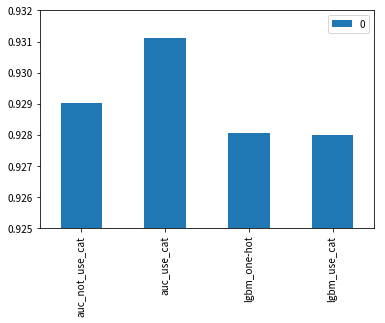

In [24]:
ax = pd.DataFrame([results]).T.plot(kind='bar')
ax.legend(loc=1)
ax.set_ylim(0.925, .932)

## 結論

catboost がつよい